##  Goal: predicting the class of a text.
### Task: Fine-tune a BERT model for sequence classification.


#### BERT-HuggingFace workflow:
#### 1- Divide your data into training and test sets.
#### 2- Encode your data into a format BERT will understand.
#### 3- Combine your data and labels into dataset objects.
#### 4- Load the pre-trained BERT model.
#### 5- Fine-tune the model using your training data.
#### 6- Predict new labels and evaluate performance on your test data.

In [1]:
# !pip3 install transformers
# !pip install gdown

In [2]:
from collections import defaultdict
import gdown
import gzip
import json
import random
import pickle

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

 ## Goodreads data

In [3]:
# dictionary with each genre and the link to the corresponding documents.

genre_url_dict = {'poetry':                 'https://drive.google.com/uc?id=1FVD3LxJXRc5GrKm97LehLgVGbRfF9TyO',
                  'children':               'https://drive.google.com/uc?id=1908GDMdrhDN7sTaI_FelSHxbwcNM1EzR',
                  'comics_graphic':         'https://drive.google.com/uc?id=1V4MLeoEiPQdocCbUHjR_7L9ZmxTufPFe',
                  'fantasy_paranormal':     'https://drive.google.com/uc?id=1THnnmE4XSCvMkGOsqapQr2cJI5amKA6X',
                  'history_biography':      'https://drive.google.com/uc?id=1lDkTzM6zpYU-HGkVAQgsw0dBzik-Zde9',
                  'mystery_thriller_crime': 'https://drive.google.com/uc?id=1ONpyuv0vrtd6iUEp0-zzkKqwpm3njEqi',
                  'romance':                'https://drive.google.com/uc?id=1NpFsDQKBj_lrTzSASfyKbmkSykzN88wE',
                  'young_adult':            'https://drive.google.com/uc?id=1M5iqCZ8a7rZRtsmY5KQ5rYnP9S0bQJVo'}

In [4]:
for _genre, _url in genre_url_dict.items():
    gdown.download(_url, _genre + '.json.gz', quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1FVD3LxJXRc5GrKm97LehLgVGbRfF9TyO
To: /home/cgarcia37/Teaching/poetry.json.gz
100%|██████████| 49.3M/49.3M [00:01<00:00, 26.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1908GDMdrhDN7sTaI_FelSHxbwcNM1EzR
To: /home/cgarcia37/Teaching/children.json.gz
100%|██████████| 172M/172M [00:05<00:00, 29.1MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1V4MLeoEiPQdocCbUHjR_7L9ZmxTufPFe
To: /home/cgarcia37/Teaching/comics_graphic.json.gz
100%|██████████| 147M/147M [00:01<00:00, 93.0MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1THnnmE4XSCvMkGOsqapQr2cJI5amKA6X
To: /home/cgarcia37/Teaching/fantasy_paranormal.json.gz
100%|██████████| 1.26G/1.26G [00:19<00:00, 66.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lDkTzM6zpYU-HGkVAQgsw0dBzik-Zde9
To: /home/cgarcia37/Teaching/history_biography.json.gz
100%|██████████| 754M/754M [00:07<00:00, 107MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1ON

In [5]:
def load_reviews(file_name,
                 head=None):

    reviews = []
    count = 0

    with gzip.open(file_name) as file:   # gzip to unzip the downloaded JSON files 
        for line in file:

            d = json.loads(line)         # json to load the JSON files once they're unzipped
            count += 1

            _book_id = d['book_id']

            reviews.append(d['review_text'])

            # Break if we reach the Nth line
            if (head is not None) and (count > head):
                break

    return reviews

In [6]:
genres = ['poetry', 'children', 'comics_graphic', 'fantasy_paranormal', 'history_biography', 'mystery_thriller_crime', 'romance', 'young_adult']
genre_reviews_dict = {}

for _genre in genres:
    print('Loading ' + _genre + '.json.gz')
    _reviews = load_reviews(_genre + '.json.gz')
    genre_reviews_dict[_genre] = random.sample(_reviews, 2000)

Loading poetry.json.gz
Loading children.json.gz
Loading comics_graphic.json.gz
Loading fantasy_paranormal.json.gz
Loading history_biography.json.gz
Loading mystery_thriller_crime.json.gz
Loading romance.json.gz
Loading young_adult.json.gz


In [106]:
for _genre, _reviews in genre_reviews_dict.items():
    print('===========================')
    print(_genre)
    print('===========================')
    print(random.sample(_reviews, 1)[0])
    print()

poetry
Before I get into the meat of this book, can I just say how awesome this cover is? If I were wandering through a bookstore on a "judging a book by its cover" binge, this would be the first book I would grab. 
 Moving on, if you know me or follow any of my book blogging habits, you know that I'm a big fan of anything written in verse. Of course, I'm a fan of any kind of general reading material, but there's something about verse writing that hits my emotions harder. I had the pleasure of stumbling across one of R.H. Sin's books at my library, and gobbled it up in one sitting. 
 Whiskey Words and a Shovel III carries the same raw emotion as the previous installment, and is just as easy to binge read as the first. I was also eager to find that this book was a hefty 336 pages long, almost twice as long as the last book! Woohoo! The feelings I have for the verse are hard to put into words, really. It's very raw and real and personal, and it almost reminds me of talking to an old frie

In [101]:
pickle.dump(genre_reviews_dict, open('genre_reviews_dict.pickle', 'wb'))
# genre_reviews_dict = pickle.load(open('genre_reviews_dict.pickle', 'rb'))

## Training and Test sets

In [9]:
train_texts = []
train_labels = []

test_texts = []
test_labels = []

for _genre, _reviews in genre_reviews_dict.items():

    _reviews = random.sample(_reviews, 1000) # Use a very small set as an example.
  
    for _review in _reviews[:800]:
        train_texts.append(_review)
        train_labels.append(_genre)
    for _review in _reviews[800:]:
        test_texts.append(_review)
        test_labels.append(_genre)

In [10]:
print("Train set: number of texts ", len(train_texts), "labels", len(train_labels))
print("Test set: number of texts ", len(test_texts), "labels", len(test_labels))

Train set: number of texts  6400 labels 6400
Test set: number of texts  1600 labels 1600


In [11]:
train_labels[0], train_texts[0]

('poetry',
 '"As for the poem, not this poem but any \n poem, do you feel its sting? Do you feel \n its hope, its entrance to a community? Do \n you feel its hand in your hand?" (p. 23) \n Yes, I do.')

## Baseline model

In [12]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [13]:
model = LogisticRegression(max_iter=1000).fit(X_train, train_labels)
predictions = model.predict(X_test)

In [14]:
print(classification_report(test_labels, predictions))

                        precision    recall  f1-score   support

              children       0.58      0.59      0.59       200
        comics_graphic       0.52      0.58      0.55       200
    fantasy_paranormal       0.36      0.31      0.33       200
     history_biography       0.51      0.43      0.47       200
mystery_thriller_crime       0.50      0.48      0.49       200
                poetry       0.62      0.70      0.66       200
               romance       0.44      0.49      0.47       200
           young_adult       0.41      0.39      0.40       200

              accuracy                           0.50      1600
             macro avg       0.49      0.50      0.49      1600
          weighted avg       0.49      0.50      0.49      1600



## Texts and labels for BERT


In [15]:
# BERT model: DistilBERT to save space (it's a distilled version of the full BERT model)
model_name = 'distilbert-base-cased'  

# Name of the program management system for NVIDIA GPUs.
device_name = 'cuda'       

# Maximum number of tokens in any document sent to BERT.
max_length = 512                                                        

# Directory where we'll save our model.
cached_model_directory_name = '/home/cgarcia37/Teaching/results/' 

In [16]:
# Labels turned into integers.
# Texts needs to be truncated/padded (512 tokens).
# Tokens separated into "word pieces" and matched to their embedding vectors.
# Add special tokens: [CLS], [SEP], [PAD], [##]
# Less frequent words will be split into two or more pieces. (prefix ##)

In [17]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

### Labels

In [18]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [19]:
label2id
#label2id.keys()
#label2id.values()
#label2id['poetry']

{'fantasy_paranormal': 0,
 'romance': 1,
 'mystery_thriller_crime': 2,
 'young_adult': 3,
 'history_biography': 4,
 'comics_graphic': 5,
 'children': 6,
 'poetry': 7}

In [20]:
id2label
#id2label.keys()
#id2label.values()
#id2label[0]

{0: 'fantasy_paranormal',
 1: 'romance',
 2: 'mystery_thriller_crime',
 3: 'young_adult',
 4: 'history_biography',
 5: 'comics_graphic',
 6: 'children',
 7: 'poetry'}

### Encode texts and labels

In [21]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

In [108]:
# Training Goodreads review example after encoding

' '.join(train_encodings[3].tokens[0:100])

'[CLS] Series of mon ##olo ##gues , adapted from mythological or historical figures from ancient Greece , inter ##spersed with diary fragments about love . Not really sure what else to say about this one . Du ##mb ##founded . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [109]:
train_texts[3]

'Series of monologues, adapted from mythological or historical figures from ancient Greece, interspersed with diary fragments about love. \n Not really sure what else to say about this one. Dumbfounded.'

In [87]:
# # Test Goodreads review example

' '.join(test_encodings[0].tokens[0:512])

'[CLS] Sa ##ssy is the first word that springs into my mind when I think of Mei ##t ##ner \' s writing . Her poems are clearly urban . New York City r ##hum ##bas throughout this collection ; there are poems about riding the subway , descriptions of neighborhoods , and an exquisite series of poems about Mei ##t ##ner \' s experience as a no ##vice inner - city school teacher . She writes with a head - on , take - no - prisoners voice . These are narrative poems , and most employ long lines . Most of the poems are long , and dense on the page , although there are several written in couple ##ts . The first section deals primarily with ad ##ole ##scence . " All The Pool ##s In Queens " talks about a summer job as a life ##guard . In the heat people s ##lump and f ##use like glass , edges round ##ing , topography melting for good . The ex - con ##s in for free swim - sex offenders at the local halfway house - pretend to drown . Mei ##t ##ner squeeze ##s everything she can out of large , s 

In [25]:
test_texts[0]

'Sassy is the first word that springs into my mind when I think of Meitner\'s writing. Her poems are clearly urban. New York City rhumbas throughout this collection; there are poems about riding the subway, descriptions of neighborhoods, and an exquisite series of poems about Meitner\'s experience as a novice inner-city school teacher. She writes with a head-on, take-no-prisoners voice. These are narrative poems, and most employ long lines. Most of the poems are long, and dense on the page, although there are several written in couplets. \n The first section deals primarily with adolescence. "All The Pools In Queens" talks about a summer job as a lifeguard. \n In the heat people slump and fuse \n like glass, edges rounding, topography \n melting for good. The ex-cons in for free swim- \n sex offenders at the local halfway house- \n pretend to drown. \n Meitner squeezes everything she can out of large, swooping metaphors. In "Rubber," she compares the experience of going to a gyn clinic

In [26]:
# training labels

set(train_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

In [27]:
# test labels

set(test_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

## Torch dataset

In [28]:
#print(train_encodings[0].tokens, train_encodings[0].ids, train_encodings[0].attention_mask)
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [29]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [30]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

In [31]:
# Training example in the Torch dataset 

' '.join(train_dataset.encodings[0].tokens[0:100])

'[CLS] " As for the poem , not this poem but any poem , do you feel its sting ? Do you feel its hope , its entrance to a community ? Do you feel its hand in your hand ? " ( p . 23 ) Yes , I do . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

## Load the pretrained-model

In [32]:
# The model_name needs to match the name used for the tokenizer above.

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.w

## BERT fine-tuning parameters --> HuggingFace

In [33]:
training_args = TrainingArguments(
    num_train_epochs=12,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

In [34]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
  }

In [35]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function 
)

In [36]:
trainer.train()

/home/cgarcia37/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running training *****
  Num examples = 6400
  Num Epochs = 12
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
 

Step,Training Loss,Validation Loss,Accuracy
100,1.879800,1.445713,0.491875
200,1.315900,1.323290,0.522500
300,0.962400,1.359695,0.538125
400,0.667300,1.453699,0.538125
500,0.440600,1.585913,0.533125
600,0.280600,1.760623,0.530625
700,0.175300,1.884111,0.525000
800,0.109600,2.065855,0.540000
900,0.076900,2.146745,0.529375
1000,0.049200,2.299671,0.535625


***** Running Evaluation *****
  Num examples = 1600
  Batch size = 80
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 80
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was aske

TrainOutput(global_step=1200, training_loss=0.5020462010304133, metrics={'train_runtime': 494.9089, 'train_samples_per_second': 155.18, 'train_steps_per_second': 2.425, 'total_flos': 1.01745847959552e+16, 'train_loss': 0.5020462010304133, 'epoch': 12.0})

In [37]:
trainer.save_model(cached_model_directory_name)

Saving model checkpoint to /home/cgarcia37/Teaching/results/
Configuration saved in /home/cgarcia37/Teaching/results/config.json
Model weights saved in /home/cgarcia37/Teaching/results/pytorch_model.bin


In [38]:
# To evaluate you can use your saved model

#trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)

## Evaluate

In [39]:
trainer.evaluate()

/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 80
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.3668019771575928,
 'eval_accuracy': 0.53375,
 'eval_runtime': 3.2361,
 'eval_samples_per_second': 494.425,
 'eval_steps_per_second': 6.18,
 'epoch': 12.0}

In [40]:
predicted_results = trainer.predict(test_dataset)

/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running Prediction *****
  Num examples = 1600
  Batch size = 80
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [41]:
predicted_results.predictions.shape

(1600, 8)

In [84]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the index -> highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [43]:
len(predicted_labels)

1600

In [44]:
print(classification_report(test_labels, predicted_labels))

                        precision    recall  f1-score   support

              children       0.56      0.60      0.58       200
        comics_graphic       0.67      0.66      0.66       200
    fantasy_paranormal       0.40      0.42      0.41       200
     history_biography       0.57      0.48      0.52       200
mystery_thriller_crime       0.55      0.53      0.54       200
                poetry       0.76      0.71      0.73       200
               romance       0.51      0.46      0.48       200
           young_adult       0.33      0.40      0.36       200

              accuracy                           0.53      1600
             macro avg       0.54      0.53      0.54      1600
          weighted avg       0.54      0.53      0.54      1600



# Correct and Incorrect classifications

In [45]:
# Correct

for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 10):
    if _true_label == _predicted_label:
        print('LABEL:', _true_label)
        print('REVIEW TEXT:', _text[:100], '...')
        print()

LABEL: romance
REVIEW TEXT: Snarky me has never read a Christmas romance. I generally stay away from them just on principle. How ...

LABEL: young_adult
REVIEW TEXT: Everytime I read something written by Marie Lu , I end up in tears. Right now, I am crying so hard.  ...

LABEL: comics_graphic
REVIEW TEXT: Not... 
 Not surprising that the doctor can have a sense of humor. This was amazing and even as comi ...

LABEL: young_adult
REVIEW TEXT: This book was alright, took me a while to read. The ending is very surprising, and the general theme ...

LABEL: children
REVIEW TEXT: Once you've read Diary of a Wombat, you are probably primed to love "How to Scratch a Wombat," which ...



In [46]:
# Incorrect

for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 10):
    if _true_label != _predicted_label:
        print('TRUE LABEL:', _true_label)
        print('PREDICTED LABEL:', _predicted_label)
        print('REVIEW TEXT:', _text[:100], '...')
        print()

TRUE LABEL: romance
PREDICTED LABEL: young_adult
REVIEW TEXT: I don't know how I got out of sequence. I think this part of the series may be one of my faves. ...

TRUE LABEL: mystery_thriller_crime
PREDICTED LABEL: young_adult
REVIEW TEXT: waited a long time to read this as it wasn't available in the uk. Finally got it for free through my ...

TRUE LABEL: poetry
PREDICTED LABEL: history_biography
REVIEW TEXT: Reading this was hard to remember. About the greeks and the war and helen who was stolen and the tro ...

TRUE LABEL: romance
PREDICTED LABEL: young_adult
REVIEW TEXT: I loveeeedd this book, it was better than I thought it would be. It doesnt has this crazy plot twist ...

TRUE LABEL: history_biography
PREDICTED LABEL: mystery_thriller_crime
REVIEW TEXT: I did not enjoy this quite as much as I expected. A good listen but was not overwhelmed. I think par ...



In [47]:
# Heatmaps to examine misclassification

genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
    genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
    dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

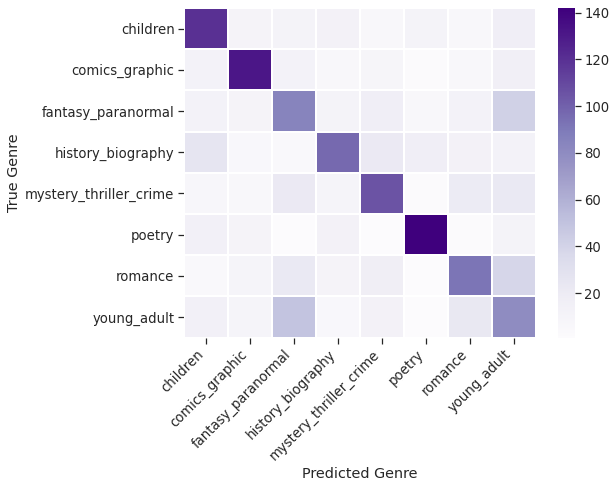

In [48]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [49]:
# Remove the diagonal from the plot to highlight the misclassifications

genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
    if _true_label != _predicted_label: # Remove the diagonal to highlight misclassifications
        genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
    dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

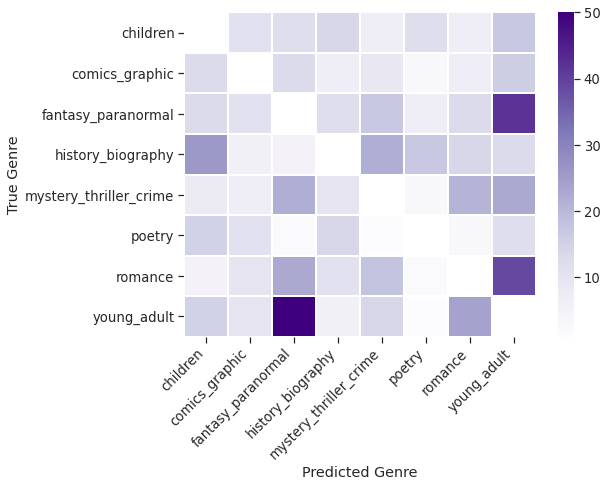

In [50]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()